## <font color=blue>Diabetes dataset<font>

In [1]:
%matplotlib inline
#%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

In [2]:
# df = pd.read_csv("diabetic_data.csv", dtype='category').iloc[:500,2:]
df = pd.read_csv("diabetic_data.csv", dtype='category').iloc[:,2:]
df.shape

(101766, 48)

In [3]:
df.describe()

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
count,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,...,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766
unique,6,3,10,10,8,26,17,14,18,73,...,1,4,4,2,2,2,2,2,2,3
top,Caucasian,Female,[70-80),?,1,1,7,3,?,?,...,No,No,No,No,No,No,No,No,Yes,NO
freq,76099,54708,26068,98569,53990,60234,57494,17756,40256,49949,...,101766,47383,101060,101753,101765,101764,101765,54755,78363,54864


In [4]:
def show_unique(dataF):
    for c in dataF.columns:
        print(c, dataF[c].unique())
        print('*'*50)

show_unique(df)

race [Caucasian, AfricanAmerican, ?, Other, Asian, Hispanic]
Categories (6, object): [Caucasian, AfricanAmerican, ?, Other, Asian, Hispanic]
**************************************************
gender [Female, Male, Unknown/Invalid]
Categories (3, object): [Female, Male, Unknown/Invalid]
**************************************************
age [[0-10), [10-20), [20-30), [30-40), [40-50), [50-60), [60-70), [70-80), [80-90), [90-100)]
Categories (10, object): [[0-10), [10-20), [20-30), [30-40), ..., [60-70), [70-80), [80-90), [90-100)]
**************************************************
weight [?, [75-100), [50-75), [0-25), [100-125), [25-50), [125-150), [175-200), [150-175), >200]
Categories (10, object): [?, [75-100), [50-75), [0-25), ..., [125-150), [175-200), [150-175), >200]
**************************************************
admission_type_id [6, 1, 2, 3, 4, 5, 8, 7]
Categories (8, object): [6, 1, 2, 3, 4, 5, 8, 7]
**************************************************
discharge_disposition_

### <font color =blue>1. remove columns with missing data</font>

In [5]:
#replacing medical speciality with missing
df = df.drop(columns=['weight', 'payer_code' , 'medical_specialty'])
df.head(2)

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),6,25,1,1,41,0,1,...,No,No,No,No,No,No,No,No,No,NO
1,Caucasian,Female,[10-20),1,1,7,3,59,0,18,...,No,Up,No,No,No,No,No,Ch,Yes,>30


### <font color=blue> 2. remove incomplete columns and rows </font>

In [6]:
df = df.drop(columns= df.columns[df.nunique() == 1])

### <font color = blue>3. categorical variables</font>

In [7]:
df["age"] = np.where(df.age == '[0-10)','[0-30]', np.where(df.age == '[10-20)','[0-30]',
                 np.where(df.age == '[20-30)','[0-30]',np.where(df.age == '[30-40)','[30-60]',np.where(df.age == '[40-50)'
                 ,'[30-60]',np.where(df.age == '[50-60)','[30-60]','[60-100]'))))))

In [8]:
to_num = ['time_in_hospital', 'num_lab_procedures', 'num_procedures',
         'num_medications', 'number_outpatient', 'number_emergency',
         'number_inpatient', 'number_diagnoses']

to_cat_codes = list(set(df.columns) - set(to_num))


In [9]:
df.age = df['age'].astype('category')

In [10]:
X_features = list(to_num)
for c in to_cat_codes:
    df[c+'_cat'] = df[c].cat.codes
    X_features += [c+'_cat']
    
X_features.remove('readmitted_cat')

In [11]:
df["readmitted_bin"] = np.where(df.readmitted == '<30', 1, np.where(df.readmitted == '>30',1,0))  
df[["readmitted","readmitted_bin"]].head(10)
X_features.append("readmitted_bin")

In [12]:
df = df[X_features]


#### <font color=red>Target Mapping: < 30 = 1, >30 = 1, NO = 0, </font>

### <font color=blue>4. split</font>

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    df.loc[:, df.columns != 'readmitted_bin'], df['readmitted_bin'] , random_state = 0)

In [14]:
print(X_train.columns)
print(y_train.shape)

Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'max_glu_serum_cat',
       'acarbose_cat', 'A1Cresult_cat', 'insulin_cat', 'chlorpropamide_cat',
       'troglitazone_cat', 'metformin-pioglitazone_cat',
       'glyburide-metformin_cat', 'admission_source_id_cat',
       'rosiglitazone_cat', 'diabetesMed_cat', 'race_cat',
       'glipizide-metformin_cat', 'tolbutamide_cat', 'diag_2_cat',
       'miglitol_cat', 'diag_3_cat', 'glyburide_cat', 'glipizide_cat',
       'admission_type_id_cat', 'change_cat', 'discharge_disposition_id_cat',
       'metformin_cat', 'nateglinide_cat', 'acetohexamide_cat',
       'tolazamide_cat', 'repaglinide_cat', 'gender_cat', 'pioglitazone_cat',
       'diag_1_cat', 'metformin-rosiglitazone_cat', 'age_cat',
       'glimepiride-pioglitazone_cat', 'glimepiride_cat'],
      dtype='object')
(76324,)


### <font color=blue>5. min max scaling</font>

In [15]:
scaler = StandardScaler()
X_train[to_num] = scaler.fit_transform(X_train[to_num])
X_test[to_num] = scaler.transform(X_test[to_num])
X_train.shape


(76324, 42)

#### after scale

## <font color=green> LinearSVM</font>

In [16]:
def plot_confusion(clf):
    svm_predicted_mc = clf.predict(X_test)
    confusion_mc = confusion_matrix(y_test, svm_predicted_mc)
    df_cm = pd.DataFrame(confusion_mc, 
                         index = [i for i in range(0,2)], columns = [i for i in range(0,2)])

    plt.figure(figsize=(6,4))
    ax_ticks= ['No','Y']
    sns.heatmap(df_cm, annot=True, xticklabels=ax_ticks, yticklabels=ax_ticks, fmt='g')
    plt.title('SVM Linear Kernel \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, 
                                                                           svm_predicted_mc)))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    print('Micro-averaged precision = {:.2f} (treat instances equally)'
      .format(precision_score(y_test, svm_predicted_mc, average = 'micro')))
    print('Macro-averaged precision = {:.2f} (treat classes equally)'
      .format(precision_score(y_test, svm_predicted_mc, average = 'macro')))
    print('Micro-averaged f1 = {:.2f} (treat instances equally)'
          .format(f1_score(y_test, svm_predicted_mc, average = 'micro')))
    print('Macro-averaged f1 = {:.2f} (treat classes equally)'
          .format(f1_score(y_test, svm_predicted_mc, average = 'macro')))
    print(classification_report(y_test, svm_predicted_mc))



In [17]:
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.figure(figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k')
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

In [18]:
%%time
clf = LinearSVC(verbose=True).fit(X_train, y_train)
print(type(clf.coef_))
print('training accuracy: {:.2f}'.format(clf.score(X_train, y_train)))
print('test accuracy: {:.2f}'.format(clf.score(X_test, y_test)))
#print(clf.coef_)


[LibLinear]

C:\Users\DELL\Anaconda3\envs\tfp3.6\lib\site-packages\sklearn\svm\base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


<class 'numpy.ndarray'>
training accuracy: 0.47
test accuracy: 0.47
Wall time: 23.7 s


# Feature Importance Matrix

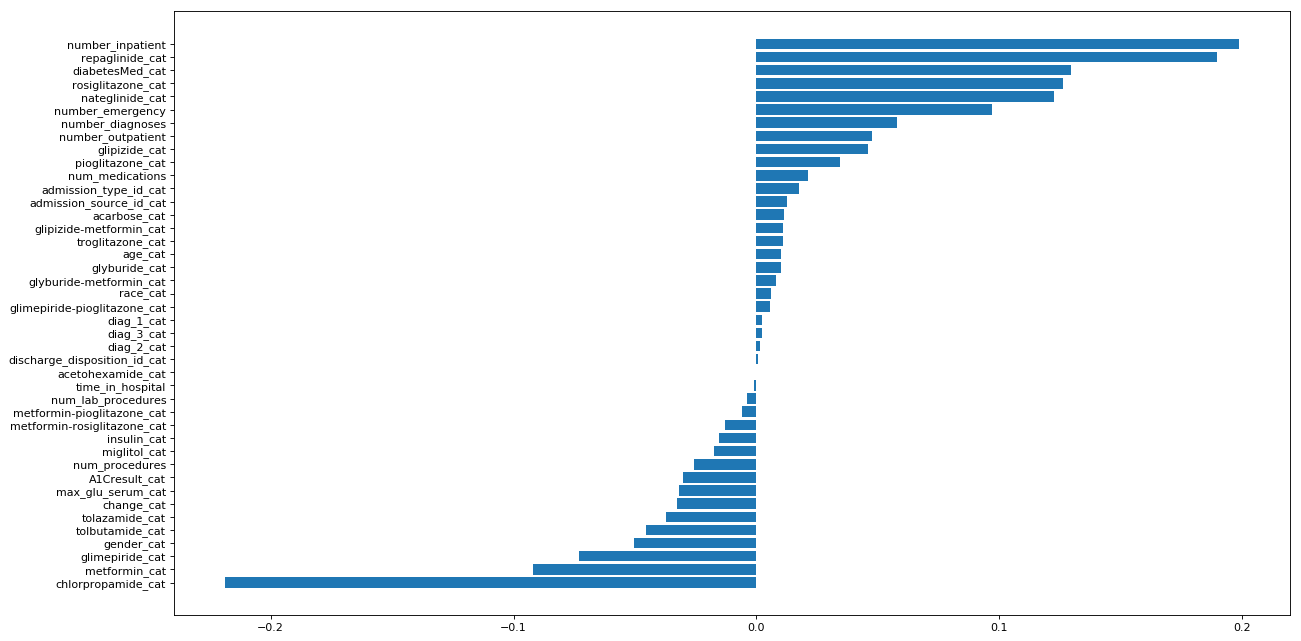

In [19]:
a = clf.coef_
b = np.reshape(a, (np.product(a.shape),))
f_importances(b, X_train.columns)

Micro-averaged precision = 0.47 (treat instances equally)
Macro-averaged precision = 0.60 (treat classes equally)
Micro-averaged f1 = 0.47 (treat instances equally)
Macro-averaged f1 = 0.33 (treat classes equally)
             precision    recall  f1-score   support

          0       0.73      0.01      0.03     13709
          1       0.46      0.99      0.63     11733

avg / total       0.61      0.47      0.31     25442



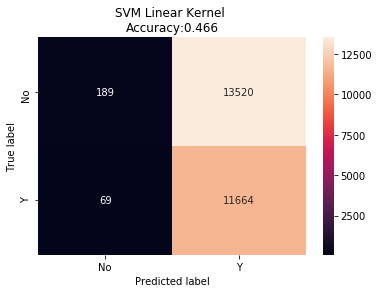

In [20]:
plot_confusion(clf)

# Taking only Numerical columns and age

In [21]:
%%time
columnslist = ['age_cat']
for c in columnslist:
    to_num.append(c)
to_num = list(set(to_num))
print(to_num)
X_train = X_train[to_num]

X_test = X_test[to_num]

clf = LinearSVC(verbose=True).fit(X_train, y_train)

print('training accuracy: {:.2f}'.format(clf.score(X_train, y_train)))
print('test accuracy: {:.2f}'.format(clf.score(X_test, y_test)))

['number_diagnoses', 'number_inpatient', 'num_procedures', 'num_lab_procedures', 'age_cat', 'time_in_hospital', 'number_outpatient', 'num_medications', 'number_emergency']
[LibLinear]

C:\Users\DELL\Anaconda3\envs\tfp3.6\lib\site-packages\sklearn\svm\base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


training accuracy: 0.61
test accuracy: 0.62
Wall time: 13.4 s


Micro-averaged precision = 0.62 (treat instances equally)
Macro-averaged precision = 0.62 (treat classes equally)
Micro-averaged f1 = 0.62 (treat instances equally)
Macro-averaged f1 = 0.59 (treat classes equally)
             precision    recall  f1-score   support

          0       0.61      0.82      0.70     13709
          1       0.64      0.38      0.47     11733

avg / total       0.62      0.62      0.59     25442



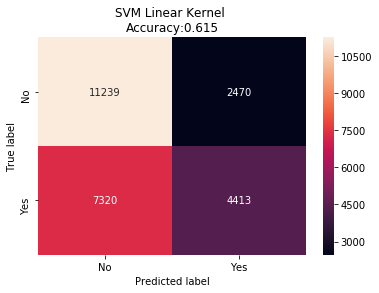

In [22]:
def plot_confusion(clf):
    svm_predicted_mc = clf.predict(X_test)
    confusion_mc = confusion_matrix(y_test, svm_predicted_mc)
    df_cm = pd.DataFrame(confusion_mc, 
                         index = [i for i in range(0,2)], columns = [i for i in range(0,2)])

    plt.figure(figsize=(6,4))
    ax_ticks= ['No','Yes']
    sns.heatmap(df_cm, annot=True, xticklabels=ax_ticks, yticklabels=ax_ticks, fmt='g')
    plt.title('SVM Linear Kernel \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, 
                                                                           svm_predicted_mc)))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    print('Micro-averaged precision = {:.2f} (treat instances equally)'
      .format(precision_score(y_test, svm_predicted_mc, average = 'micro')))
    print('Macro-averaged precision = {:.2f} (treat classes equally)'
      .format(precision_score(y_test, svm_predicted_mc, average = 'macro')))
    print('Micro-averaged f1 = {:.2f} (treat instances equally)'
          .format(f1_score(y_test, svm_predicted_mc, average = 'micro')))
    print('Macro-averaged f1 = {:.2f} (treat classes equally)'
          .format(f1_score(y_test, svm_predicted_mc, average = 'macro')))
    print(classification_report(y_test, svm_predicted_mc))

plot_confusion(clf)